In [ ]:
#default_exp callback.data

# Data Callbacks

> Callbacks which work with a learner's data

In [ ]:
#export
from fastai2.basics import *

In [ ]:
from nbdev.showdoc import *
from fastai2.test_utils import *

In [ ]:
#export
class CollectDataCallback(Callback):
    "Collect all batches, along with `pred` and `loss`, into `self.data`. Mainly for testing"
    def begin_fit(self): self.data = L()
    def after_batch(self): self.data.append(to_detach((self.xb,self.yb,self.pred,self.loss)))

In [ ]:
#export
@delegates()
class WeightedDL(TfmdDL):
    def __init__(self, dataset=None, bs=None, wgts=None, **kwargs):
        super().__init__(dataset=dataset, bs=bs, **kwargs)
        wgts = array([1.]*len(dataset) if wgts is None else wgts)
        self.wgts = wgts/wgts.sum()
        
    def get_idxs(self):
        if self.n==0: return []
        if not self.shuffle: return super().get_idxs()
        return list(np.random.choice(self.n, self.n, p=self.wgts))

In [ ]:
#export
@patch
@delegates(DataSource.databunch)
def weighted_databunch(self:DataSource, wgts, bs=64, **kwargs):
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.databunch(bs=bs, dl_type=WeightedDL, dl_kwargs=({'wgts':wgts}, *xtra_kwargs), **kwargs)

In [ ]:
n = 160
dsrc = DataSource(torch.arange(n).float())
dbch = dsrc.weighted_databunch(wgts=range(n), bs=16)
learn = synth_learner(data=dbch, cb_funcs=CollectDataCallback)

(#4) [0,nan,None,00:00]


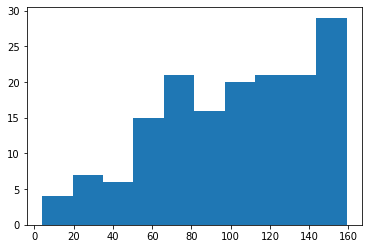

In [ ]:
learn.fit(1)
t = concat(*learn.collect_data.data.itemgot(0,0))
plt.hist(t);

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.learner.ipynb.
Converted 22_tutorial.imagenette.ipynb.
Converted 23_tutorial.transfer_learning.ipynb.
Converted